In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [2]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF # Non-Negative Matrix Factorization for Topic Modeling
from sklearn.metrics.pairwise import linear_kernel
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# --- SETUP: Ensure Reproducibility ---
# Setting a fixed random seed makes sure that every time you run the code,
# you get the exact same "random" results for consistency.
np.random.seed(42)

In [4]:
# --- SETUP: Download NLTK Components (Run Once) ---
# These are necessary libraries for text processing.
# We use try/except to prevent errors if they are already downloaded.
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
except:
    pass # Ignore errors if download fails (e.g., no internet)

# Define parameters to be used in Topic Modeling (Part 4)
N_TOPICS = 8
N_TOP_WORDS = 10

In [5]:
FILE_PATH = "/content/sample_data/Tweets.csv"
try:
    # Read the data from the CSV file
    df = pd.read_csv(FILE_PATH)
    print(f"Data imported successfully. Total rows: {df.shape[0]}")
except FileNotFoundError:
    print(f"ERROR: File not found at {FILE_PATH}. Check file name.")
    exit()

# Show the first 5 rows to understand the data structure
print("\nFirst 5 Rows of Data:")
print(df.head())

Data imported successfully. Total rows: 14640

First 5 Rows of Data:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin  

/tmp/ipython-input-2610820695.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df, order=['negative', 'neutral', 'positive'], palette='viridis')


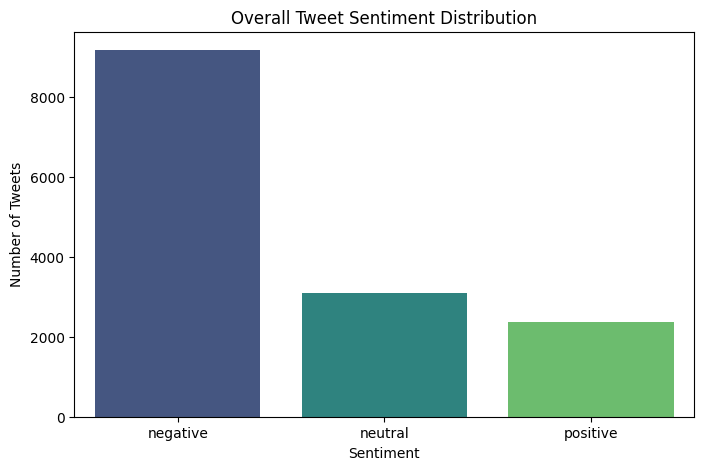

In [6]:
# --- EDA Visualization 1: Overall Sentiment Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='airline_sentiment', data=df, order=['negative', 'neutral', 'positive'], palette='viridis')
plt.title('Overall Tweet Sentiment Distribution')
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
plt.show()

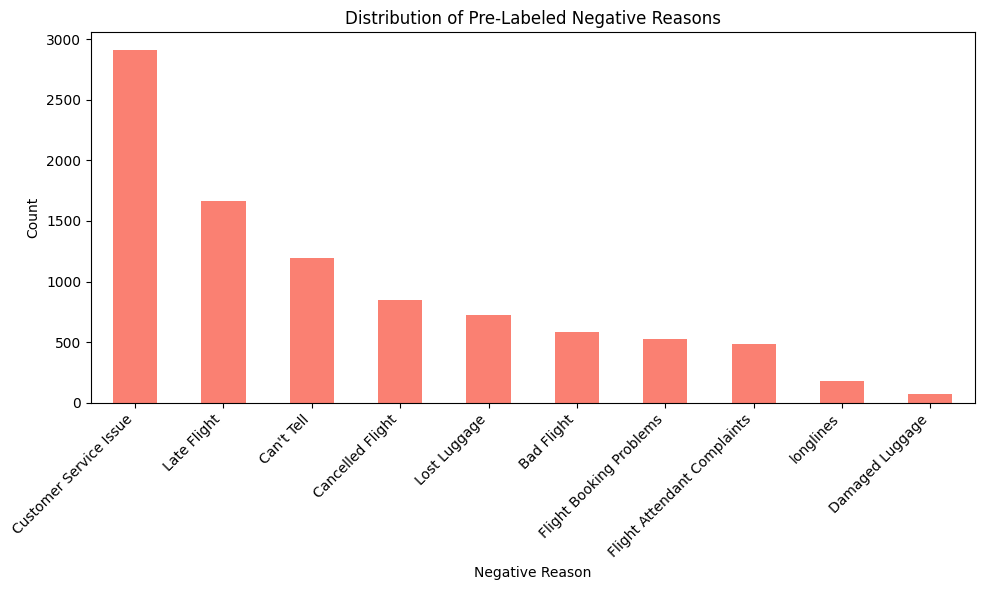

--------------------------------------------------


In [7]:
# --- EDA Visualization 2: Negative Reasons ---
# We only care about the tweets that were labeled 'negative'
negative_df = df[df['airline_sentiment'] == 'negative'].copy()

plt.figure(figsize=(10, 6))
# Count how many times each 'negativereason' appears and plot the results
negative_df['negativereason'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of Pre-Labeled Negative Reasons')
plt.ylabel('Count')
plt.xlabel('Negative Reason')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("-" * 50)

In [8]:
# ==============================================================================
# 3) TEXT PREPROCESSING (15%)
# ==============================================================================
print("--- 3. Text Preprocessing ---")

# Setup the tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """ Cleans text by removing noise, stop words, and standardizing words. """
    # Convert to lowercase
    text = text.lower()

    # Remove twitter handles (starting with @)
    text = re.sub(r'@\w+', '', text)

    # Remove URLs (starting with http or www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Keep only alphabetic characters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Split the text into individual words (tokens)
    tokens = text.split()

    # Remove common words (stop words) and simplify words (lemmatization)
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words and len(word) > 2: # Keep words longer than 2 chars
            cleaned_word = lemmatizer.lemmatize(word)
            cleaned_tokens.append(cleaned_word)

    # Join the cleaned words back into a single string
    return " ".join(cleaned_tokens)

# Apply the cleaning function to the 'text' column of our negative tweets
negative_df['cleaned_text'] = negative_df['text'].apply(clean_text)

print("\nExample of Text Cleaning:")
sample = negative_df.iloc[0]
print(f"Original: {sample['text']}")
print(f"Cleaned: {sample['cleaned_text']}")

print("-" * 50)

--- 3. Text Preprocessing ---

Example of Text Cleaning:
Original: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Cleaned: really aggressive blast obnoxious entertainment guest face amp little recourse
--------------------------------------------------


In [9]:
# ==============================================================================
# 4) TOPIC MODELING (20%)
# ==============================================================================
print("--- 4. Topic Modeling (NMF) ---")

# --- Step 1: Create a Document-Term Matrix (DTM) ---
# This converts text into a numerical matrix where rows are tweets and columns are words.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(negative_df['cleaned_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# --- Step 2: Apply Non-Negative Matrix Factorization (NMF) ---
# NMF is an algorithm that finds topics (groups of related words) in the DTM.
nmf_model = NMF(n_components=N_TOPICS, random_state=42, max_iter=300)
nmf_model.fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    """ A simple function to print the most important words for each topic. """
    print(f"\nIdentified Topics (N={N_TOPICS}):")
    for topic_idx, topic in enumerate(model.components_):
        # Find the indices of the top words
        top_feature_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_feature_indices]
        print(f"Topic {topic_idx+1}: {' '.join(top_words)}")

# Display the topics
display_topics(nmf_model, tfidf_feature_names, N_TOP_WORDS)

# --- Step 3: Assign the best topic to each tweet ---
topic_scores = nmf_model.transform(tfidf)
# argmax finds the index (topic ID) with the highest score for each tweet
negative_df['nmf_topic'] = topic_scores.argmax(axis=1)

--- 4. Topic Modeling (NMF) ---

Identified Topics (N=8):
Topic 1: flight delayed late delay attendant connection miss problem missed due
Topic 2: customer service terrible poor line care agent rude bad rep
Topic 3: cancelled flightled flight flighted tomorrow today rebook got one dfw
Topic 4: hour hold minute ive min waiting wait two counting delay
Topic 5: get cant help call need phone please trying back home
Topic 6: bag plane still gate waiting one sitting lost agent luggage
Topic 7: time wait minute call last min back departure every first
Topic 8: airline worst ever never experience fly ive flying guy united


/tmp/ipython-input-1204748889.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nmf_topic', data=negative_df, palette='Spectral')


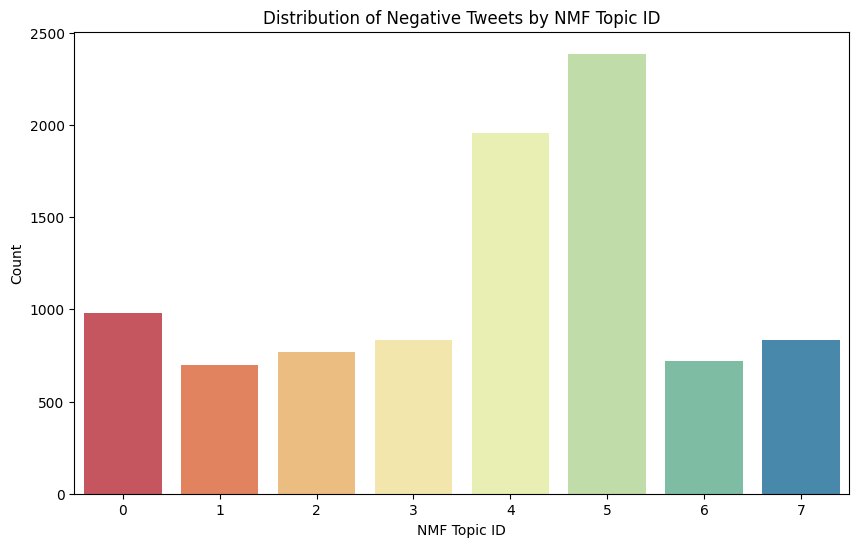

--------------------------------------------------


In [10]:
# --- Visualization: Distribution of Identified Topics ---
plt.figure(figsize=(10, 6))
sns.countplot(x='nmf_topic', data=negative_df, palette='Spectral')
plt.title('Distribution of Negative Tweets by NMF Topic ID')
plt.xlabel('NMF Topic ID')
plt.ylabel('Count')
plt.show()

print("-" * 50)

--- 5. Sentiment Analysis (VADER) ---

Mean VADER Sentiment by Topic (Most Negative First):
nmf_topic
2   -0.223601
7   -0.217523
1   -0.174426
0   -0.161289
5   -0.092378
3   -0.086773
6   -0.073722
4    0.001383
Name: vader_compound, dtype: float64


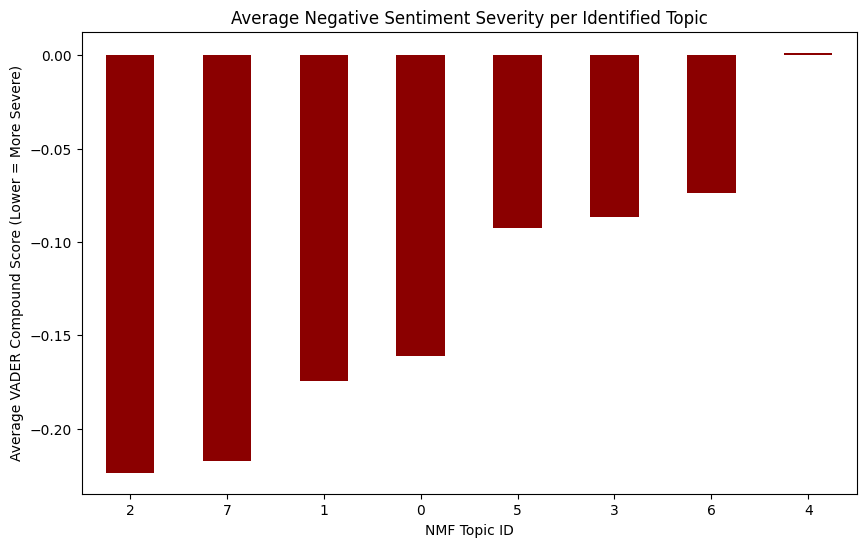

--------------------------------------------------


In [11]:
# ==============================================================================
# 5) SENTIMENT ANALYSIS (15%)
# ==============================================================================
print("--- 5. Sentiment Analysis (VADER) ---")

# Initialize VADER (a simple, rule-based sentiment tool)
sid = SentimentIntensityAnalyzer()

# Calculate VADER scores on the ORIGINAL tweet text
# The 'compound' score is the normalized, overall sentiment score (-1 is extreme negative, +1 is extreme positive)
negative_df['vader_compound'] = negative_df['text'].apply(
    lambda x: sid.polarity_scores(x)['compound']
)

# --- Key Analysis: Find the MOST SEVERE Topics ---
# Group the negative tweets by the NMF Topic and find the average VADER score.
# The lowest (most negative) average score indicates the topic that causes the most anger.
topic_sentiment = negative_df.groupby('nmf_topic')['vader_compound'].mean().sort_values()

print("\nMean VADER Sentiment by Topic (Most Negative First):")
print(topic_sentiment)

# --- Visualization: Mean Sentiment by Topic (The core actionable chart) ---
plt.figure(figsize=(10, 6))
topic_sentiment.plot(kind='bar', color='darkred')
plt.title('Average Negative Sentiment Severity per Identified Topic')
plt.ylabel('Average VADER Compound Score (Lower = More Severe)')
plt.xlabel('NMF Topic ID')
plt.xticks(rotation=0)
plt.show()

print("-" * 50)

In [12]:
# 6) CONTENT-BASED RECOMMENDER (20%)
# ==============================================================================
print("--- 6. Content-Based Recommender ---")

# For the recommender, we use all original data for better context
all_df = df.copy()
all_df['cleaned_text'] = all_df['text'].apply(clean_text)

# --- Step 1: Create TF-IDF Matrix (includes bigrams for better context) ---
tfidf_recommender = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf_recommender.fit_transform(all_df['cleaned_text'])

# --- Step 2: Compute Cosine Similarity ---
# Cosine similarity measures the angle between two vectors (tweets) in the matrix.
# A score close to 1.0 means the tweets are very similar in content.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

def get_recommendations(target_index, sim_matrix, data, top_n=3):
    """ Finds and returns the top N tweets most similar to the target tweet. """
    # Get the similarity scores for the target tweet from the matrix
    sim_scores = list(enumerate(sim_matrix[target_index]))

    # Sort the tweets by similarity score (highest first)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the top N most similar tweets (excluding the target tweet itself)
    tweet_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Return the data for the recommended tweets
    return data.iloc[tweet_indices]

# --- Step 3: Test the Recommender ---
# Pick a random negative tweet from the original data to test the function
target_index = negative_df.sample(1).index[0]
target_tweet = df.loc[target_index]

print(f"\n--- Target Tweet to Find Similar Issues ---")
print(f"Sentiment: {target_tweet['airline_sentiment']}")
print(f"Text: {target_tweet['text']}")

# Get and print the similar tweets
recommendations = get_recommendations(target_index, cosine_sim, all_df, top_n=3)

print("\n--- Top 3 Recommended Tweets (Similar Issues/Content) ---")
for i, row in recommendations.iterrows():
    # The actual similarity score is at cosine_sim[target_index, i]
    print(f"  Sentiment: {row['airline_sentiment']}")
    print(f"  Text: {row['text']}")
    print("-" * 50)

print("-" * 50)

--- 6. Content-Based Recommender ---

--- Target Tweet to Find Similar Issues ---
Sentiment: negative
Text: @united gate C 24 IAD. U released passengers to board w/others deplaning .50 peopleOn bridge while next flight  board http://t.co/HfoF33iyhi

--- Top 3 Recommended Tweets (Similar Issues/Content) ---
  Sentiment: neutral
  Text: @united at the gate! IAD to RDU
--------------------------------------------------
  Sentiment: negative
  Text: @SouthwestAir no had to rebook my flight myself and am about to board in bham.
--------------------------------------------------
  Sentiment: positive
  Text: @united 1632 was phenomenal frm gate (SEA) to gate (IAD)
--------------------------------------------------
--------------------------------------------------


In [15]:
# 7) COMMUNICATION & PRESENTATION (15%)
# ==============================================================================
print("--- 7. Final Summary and Recommendation ---")

# Create a DataFrame to store topic keywords for easy lookup
topic_words_list = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_feature_indices = topic.argsort()[:-N_TOP_WORDS - 1:-1]
    top_words = [tfidf_feature_names[i] for i in top_feature_indices]
    topic_words_list.append(top_words)

topic_df = pd.DataFrame(topic_words_list, index=range(N_TOPICS))

most_severe_topic_id = topic_sentiment.index[0]
most_severe_topic_words = topic_df.loc[most_severe_topic_id].values

print("\nFINAL ACTIONABLE RECOMMENDATION:")
print(f"The most critical issue driving customer anger is **Topic {most_severe_topic_id}**, which has the lowest average LLM sentiment score.")
print(f"This topic is characterized by keywords: {list(most_severe_topic_words)}.")
print("Recommendation: Customer support should prioritize creating specific, immediate response templates for tweets under this topic. The Content-Based Recommender can be used by agents to quickly pull up similar past issues to ensure consistent and high-quality responses.")
print("=" * 80)

--- 7. Final Summary and Recommendation ---

FINAL ACTIONABLE RECOMMENDATION:
The most critical issue driving customer anger is **Topic 2**, which has the lowest average LLM sentiment score.
This topic is characterized by keywords: ['cancelled', 'flightled', 'flight', 'flighted', 'tomorrow', 'today', 'rebook', 'got', 'one', 'dfw'].
Recommendation: Customer support should prioritize creating specific, immediate response templates for tweets under this topic. The Content-Based Recommender can be used by agents to quickly pull up similar past issues to ensure consistent and high-quality responses.
